In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import hashlib

import dask
import xarray as xr
import xrspatial
from dask.diagnostics import ProgressBar
from geocube.api.core import make_geocube

import matplotlib.pyplot as plt
import seaborn as sns

PATH = "D:\World Bank\CLIENT v2"
DATA_RAW = rf"{PATH}\Data\Data_raw"
DATA_PROC = rf"{PATH}\Data\Data_proc"
DATA_OUT = rf"{PATH}\Data\Data_out"
GPW_PATH = rf"D:\Datasets\Gridded Population of the World"

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\cupy\_environment.py:216: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
# floods = pd.read_csv(rf"{DATA_RAW}\Floods\GloFAS_floods.csv")

def load_population_data(bounds=None, generate=False):
    print("Processing Population data...")

    # Select all files in GPW folder
    files = os.listdir(GPW_PATH)
    files = [f for f in files if f.endswith(".tif")]
    
    # Compile into a single dataset
    dss = []
    for f in tqdm(files):
        
        ds = xr.open_dataset(os.path.join(GPW_PATH, f), chunks={"x": 10000, "y": 10000})
        ds["band_data"] = ds["band_data"].astype(np.uint32)
        if bounds is not None:
            ds = ds.sel(
                x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
            )
        if generate:
            with ProgressBar():
                ds.sel(band=1).drop_vars("band").band_data.rio.to_raster(rf"{DATA_PROC}\{f.replace('.tif','_proc.tif')}")
                print(f"Saved {f.replace('.tif','_proc.tif')}")
        
        ds["year"] = int(f.split("_")[5])
        ds = ds.set_coords('year')
        dss += [ds]
        
    population = xr.concat(dss, dim="year")    
    
    # Filter if bounds are provided
    if bounds is not None:
        population = population.sel(
            x=slice(bounds[0], bounds[2]), y=slice(bounds[3], bounds[1])
        )
        
    # Clean band dimension
    population = population.sel(band=1).drop_vars(["band"])
    
    print("Done!")
    return population

def load_precipitation_data():
    era5 = xr.open_dataset(
        rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc",
        chunks={"latitude": 100, "longitude": 100},
    )
    era5 = era5.rename({"latitude": "y", "longitude": "x"})
    return

def load_WB_country_data(drop_adm2_na=False):
    print("Loading World Bank country data...")
    WB_country = gpd.read_file(rf"{DATA_RAW}\world_bank_adm2.zip")
    
    # Assign nan when ADM2 is not available 
    WB_country.loc[WB_country.ADM2_NAME == "Administrative unit not available", "ADM2_CODE"] = (
        np.nan
    )
    
    # Create ADM_LAST variable: ADM2_NAME if available, else ADM1_NAME
    WB_country["ADMLAST_CODE"] = WB_country.ADM2_CODE
    WB_country["ADMLAST_NAME"] = WB_country.ADM2_NAME
    WB_country.loc[WB_country.ADM2_CODE.isnull(), "ADMLAST_CODE"] = WB_country.ADM1_CODE
    WB_country.loc[ WB_country.ADM2_CODE.isnull(), "ADMLAST_NAME"] = WB_country.ADM1_NAME

    # Dissolve by ADM_LAST and country code
    WB_country = WB_country.dissolve(by=["ADMLAST_CODE", "ADMLAST_NAME", "ADM0_CODE", "ADM0_NAME"]).reset_index()
    
    # Create ID
    WB_country["ID"] = WB_country.groupby(["ADMLAST_CODE", "ADMLAST_NAME", "ADM0_CODE", "ADM0_NAME"]).ngroup()
    assert WB_country.ID.nunique() == WB_country.shape[0], "ID is not unique!, there's some bug in the code..."
    print("Data loaded!")
    return WB_country


def rasterize_shape_like_dataset(shape, dataset):
    print("Rasterizing shape...")
    raster = make_geocube(
        vector_data=shape,
        like=dataset,
    )
    # For some reason, like option is not working, so I have to manually add x and y
    assert (raster["x"].shape == dataset["x"].shape)
    assert (raster["y"].shape == dataset["y"].shape)
    raster["x"] = dataset["x"]
    raster["y"] = dataset["y"]
    raster = raster.drop_vars(["spatial_ref"])
    raster = raster.chunk({"x": 100, "y": 100})
    print("Done!")
    return raster

def compute_zonal_stats(dataset, shape, value_var, groupby_var, gridded_groups=None, stats_funcs=["sum"], delayed=True):
    
    # Rasterize shape
    if gridded_groups is None:
        gridded_groups = rasterize_shape_like_dataset(shape[[groupby_var, "geometry"]], dataset)

    # Compute zonal stats  
    assert gridded_groups.chunks is not None, "Please, chunk the dataset before computing zonal stats! (e.g. dataset.chunk({'x': 100, 'y': 100})). Otherwise, you will get a MemoryError."
    assert dataset.chunks is not None, "Please, chunk the dataset before computing zonal stats! (e.g. dataset.chunk({'x': 100, 'y': 100})). Otherwise, you will get a MemoryError."

    print("Setting up zonal stats...")
    pop_by_adm = xrspatial.zonal.stats(gridded_groups[groupby_var], dataset[value_var], stats_funcs=stats_funcs)
    print("Done! Computing zonal stats...")    
    if delayed:
        return pop_by_adm
    
    with ProgressBar():
        pop_by_adm = pop_by_adm.compute()
    
    # Format zonal_stats dataframe
    pop_by_adm = pop_by_adm.rename(columns={
        "sum": value_var,
        "mean": f"{value_var}_mean",
        "zone": groupby_var,
    })
    
    result = (
        shape[[groupby_var, "geometry"]]
        .merge(pop_by_adm, on=groupby_var)
    )
    return result 

def compute_zonal_stats_over_time(dataset, shape, value_var, groupby_var, population_data=None, gridded_groups=None, stats_funcs=["mean"], delayed=True):
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)
    
    # Rasterize shape
    if gridded_groups is None:
        gridded_groups = rasterize_shape_like_dataset(shape[[groupby_var, "geometry"]], dataset)

    # Compute zonal stats  
    assert gridded_groups.chunks is not None, "Please, chunk the dataset before computing zonal stats! (e.g. dataset.chunk({'x': 100, 'y': 100})). Otherwise, you will get a MemoryError."
    assert dataset.chunks is not None, "Please, chunk the dataset before computing zonal stats! (e.g. dataset.chunk({'x': 100, 'y': 100})). Otherwise, you will get a MemoryError."
    assert "year" in dataset.dims, "Please, add a 'year' dimension to the dataset before computing zonal stats! (e.g. dataset = dataset.assign_coords(year=dataset.time.dt.year))."
 
    print("Setting up zonal stats...")
    tasks = []
    for year in tqdm(dataset["year"].values):
        dataset_year = dataset.sel(year=year).drop_vars("year")
        if population_data is not None:
            dataset_year = dataset_year * population_data.sel(year=year, method="nearest").drop_vars("year")
        else:
            dataset_year[value_var] = dataset_year[value_var].astype("float32")

        tasks += [xrspatial.zonal.stats(zones=gridded_groups[groupby_var], values=dataset_year[value_var], stats_funcs=stats_funcs)]
    if delayed:
        return tasks

    print("Done! Computing zonal stats...")        
    with ProgressBar():
        result = dask.compute(*tasks)
        
    return result 

def compile_zonal_stats_over_time(tasks_results, shape, groupby_var, value_var):
    
    # Compile results into a single df
    out_dict = {year: data.set_index("zone") for year, data in zip(range(1970,2021), tasks_results)}
    df = pd.concat(out_dict)
    df = df.reset_index()
    df = df.rename(columns={"level_0":"year"})
    
    # Format zonal_stats dataframe
    df = df.rename(columns={
        "sum": value_var,
        "mean": value_var,
        "zone": groupby_var,
    })
    
    result = (
        shape[[groupby_var, "geometry"]]
        .merge(df, on=groupby_var)
    )
    return result

def process_era5_data():
   
    # Load ERA5 data
    
    # Create droughts dummies
    
    # Annualize series
    
    return

# Procesa WB country Data (administrative boundaries) y GPW (population data)

In [3]:
WB_country = load_WB_country_data()
population = load_population_data(bounds=WB_country.total_bounds)

Loading World Bank country data...
Data loaded!
Processing Population data...


  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
 20%|██        | 1/5 [00:02<00:11,  2.80s/it]c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
c:\Users\ofici\

Done!


In [ ]:
# Rasterize WB_country
WB_country_grid = rasterize_shape_like_dataset(
    WB_country[["ID", "geometry"]], 
    population
)

WB_country_path = rf"E:\client_v2_data\WB_country_grid.nc"
print("Saving WB_country_grid...")
with ProgressBar():
    WB_country_grid.to_netcdf(WB_country_path)
        
WB_country[["ID", "OBJECTID", "ADM2_CODE", "ADM2_NAME", "ADM1_CODE", "ADM1_NAME", "ADM0_CODE", "ADM0_NAME", "ADMLAST_CODE", "ADMLAST_NAME", "geometry"]].to_feather(rf"E:\client_v2_data\WB_country_IDs.feather")

# GENERA Base de droughts, sin interpolar

In [4]:
import utils
droughts_path = rf"{DATA_OUT}\ERA5_droughts_yearly.nc"

In [ ]:
# if not os.path.exists(droughts_path):
print("Preparing droughts dataset...")
# Genera base de sequías
era5 = xr.open_dataset(rf"{DATA_OUT}\ERA5_monthly_1970-2021_SPI-SPEI.nc", chunks={'latitude': 1000, 'longitude': 1000})
# Corrije la dimensión x, que va de 0 a 360
era5 = era5.rename({'latitude': 'y', 'longitude': 'x'})
era5 = utils.coordinates_from_0_360_to_180_180(era5) # FIXME: no se si esto está andando bien, pero creo que si. VERIFICAR

# Calcula las sequías anuales
spi_yearly = era5.groupby("time.year").min()
with ProgressBar():
    spi_yearly.to_netcdf(rf"E:\client_v2_data\ERA5_yearly_1970-2021_SPI-SPEI.nc")

In [6]:
spi_yearly = xr.open_dataset(rf"{DATA_PROC}\ERA5_yearly_1970-2021_SPI-SPEI.nc", chunks={"x": 900, "y": 1800})

spi_spei_vars = [var for var in spi_yearly.data_vars if "-" in var]
for var in spi_spei_vars:
    for threshold_str in ["1_0", "1_5", "2_0", "2_5"]:
        threshold = float(threshold_str.replace("_", "."))
        threshold_str = threshold_str.replace("_", "")
        spi_yearly[f"drought_{var}_{threshold_str}sd"] = (spi_yearly[var] < -threshold).astype("bool")

spi_yearly = spi_yearly[[var for var in spi_yearly.data_vars if "drought" in var]]
spi_yearly = spi_yearly.rename({
    var: var.replace("drought_", "").replace("-", "") for var in spi_yearly.data_vars
})
with ProgressBar():
    spi_yearly.to_netcdf(droughts_path)

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


# Huracanes

{'USA': 1,
 'TOK': 1.081340104849279,
 'CMA': 1.0574618096357227,
 'HKO': 1.1326145552560645,
 'KMA': 1.1326145552560645,
 'NEW': 1.081340104849279,
 'REU': 1.1326145552560645,
 'BOM': 1.1326145552560645,
 'NAD': 1.1326145552560645,
 'WEL': 1.1326145552560645,
 'DS8': 1,
 'TD6': 1,
 'TD5': 1,
 'NEU': 1,
 'MLC': 1}

In [43]:
## FIXED Parameters
sshws_min_wind = {
    # Saffir-Simpson Hurricane Wind Scale
    # Measured in knots
    # https://www.nhc.noaa.gov/aboutsshws.php
    5: 137,
    4: 113,
    3: 96,
    2: 83,
    1: 64,
}

agency_measurements = {
    "USA": 1, # 1-m measurement
    "TOK": 3, # 3-m measurement
    "CMA": 2, # 2-m measurement
    "HKO": 10, # 10-m measurement
    "KMA": 10,
    "NEW": 3,
    "REU": 10,
    "BOM": 10,
    "NAD": 10,
    "WEL": 10,
    "DS8": 1,
    "TD6": 1,
    "TD5": 1,
    "NEU": 1,
    "MLC": 1,
}

conversion_factor_to_1m = {
    1: 1,
    2: (1.22/1.15+1.17/1.11)/2,
    3: (1.22/1.12+1.17/1.09)/2,
    10: (1.22/1.06+1.17/1.05)/2,
}

agency_1m_conversion_factor = {
    k:conversion_factor_to_1m[v] for k, v in agency_measurements.items()
}

## Functions
def convert_wind_to_1m(wind, agency):
    if agency in agency_1m_conversion_factor:
        return wind * agency_1m_conversion_factor[agency]
    return wind

def convert_wind_to_sshws(wind):
    for cat, min_wind in sshws_min_wind.items():
        if wind >= min_wind:
            return cat
    return 0



In [48]:
col = wind_cols[0]
agency = col.split("_")[0]
agency

'USA'

In [56]:
import geopandas as gpd

gdf = gpd.read_file(r"D:\Datasets\International Best Track Archive for Climate Stewardship (IBTrACS)\IBTrACS.ALL.list.v04r01.lines.shp")#, "BASIN", "SUBBASIN", "NAME", "ISO_TIME", "LAT", "LON", "WMO_WIND", "WMO_PRES", "WMO_AGENCY", "TRACK_TYPE"])

# Fill interpolated xy values
gdf["WMO_WIND"] = gdf["WMO_WIND"].ffill()

# Data from 1950 onwards
gdf["year"] = gdf["SEASON"].astype(int)
gdf = gdf[gdf["year"] >= 1970]

# Convert each Agency wind to 1m-MSW
wind_cols = [col for col in gdf.columns if "_WIND" in col and "WMO_WIND" not in col]
agencies = [col.replace("_WIND", "") for col in wind_cols]

for col in tqdm(wind_cols):
    agency = col.split("_")[0]
    gdf[col] = gdf[col].apply(lambda x: convert_wind_to_1m(x, agency))

gdf["wind_speed"] = gdf[wind_cols].max(axis=1)

# Convert wind to SSHWS category
gdf["category"] = gdf["wind_speed"].apply(convert_wind_to_sshws)

KeyboardInterrupt: 

In [57]:
gdf.groupby("SID")["category"].max().value_counts() 


category
0    3262
1     913
4     658
3     456
2     441
5     243
Name: count, dtype: int64

In [55]:
gdf["category"]

334678    0
334679    0
334680    0
334681    0
334682    0
         ..
698802    3
698803    4
698804    4
698805    4
698806    4
Name: category, Length: 361476, dtype: int64

In [6]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

buffers = [0.1, 0.25, 0.50, 1.00]
years = gdf["year"].unique()

paths_by_year = {}
for year in tqdm(years, leave=False):
    paths_by_year[year] = []
    for buffer in buffers:
        ### Filter year and create raster map based on the buffered best-track 
        ###     of the hurricane
        
        gdf_year = gdf[gdf.year == year]
        gdf_year = gdf_year[["wind_speed", "geometry"]]

        # Apply buffer to center of the storm
        gdf_year["geometry"] = gdf_year.geometry.buffer(buffer)
        
        # Make the biggest shock at a certain location the one shown in the xr.dataset 
        gdf_year = gdf_year.sort_values("wind_speed", ascending=True)
        raster = make_geocube(
            vector_data=gdf_year,
            like=population,
        )
        raster = raster.assign_coords({"year": year})

        for category in [1, 2, 3, 4, 5]:
            ### Once the raster wind_speed is created, create a new boolean raster 
            ###     where the winds are greater than the minimum for the category
            varname = f"category_{category}_b{int(buffer*100)}"
            # Keep only hurricanes of a certain category
            raster_b = xr.where(
                raster.rename({"wind_speed":varname})[varname] >= sshws_min_wind[category], 
                True, 
                False
            )
            # Transform wind_speed to boolean

            raster_path = rf"{DATA_PROC}\hurricanes\IBTrACS_{year}_{varname}.nc"
            raster_b.to_netcdf(raster_path, encoding={varname:{"zlib": True, "complevel": 7}})
            paths_by_year[year] += [raster_path]
            
        # xr.concat(dss, dim="year")


KeyboardInterrupt: 

In [7]:
paths_by_year

{1970: ['D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_1_b10.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_2_b10.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_3_b10.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_4_b10.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_5_b10.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_1_b25.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_2_b25.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_3_b25.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_4_b25.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_5_b25.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\Data_proc\\hurricanes\\IBTrACS_category_1_b50.nc',
  'D:\\World Bank\\CLIENT v2\\Data\\D

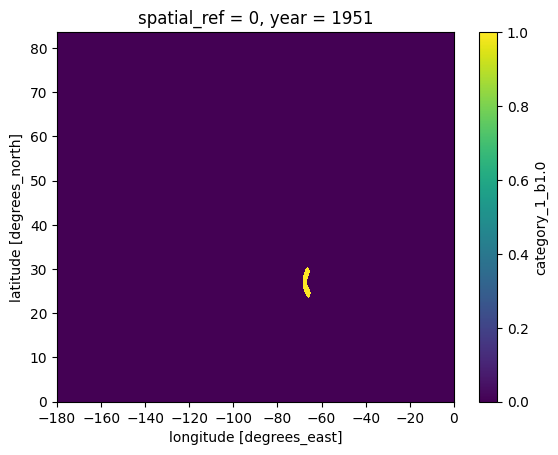

In [14]:
import xarray as xr
xr.open_dataset(r"D:\World Bank\CLIENT v2\Data\Data_proc\hurricanes\IBTrACS_cat1_1951_1.0.nc")["category_1_b1.0"].sel(x=slice(None, 0), y=slice(None, 0)).plot()